<a href="https://colab.research.google.com/github/PMDixit/handGesture/blob/main/resnet9with400x400.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets mediapipe --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 26.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
%matplotlib inline
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

matplotlib.rcParams['figure.facecolor'] = '#ffffff'#to keep background white

In [ ]:
project_name='indian-sign-language'

In [ ]:
dataset_url = "https://www.kaggle.com/vaishnaviasonawane/indian-sign-language-dataset"
dataset_url = "https://www.kaggle.com/saurabh24999/indian-sign-language"
#dataset_url="https://www.kaggle.com/datasets/kapillondhe/american-sign-language"
#prajwalmdixit
#6960242e59b78799065573dee90d4200
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalmdixit
Your Kaggle Key: ··········


100%|██████████| 1.11G/1.11G [00:18<00:00, 63.4MB/s]


In [ ]:
# Look into the data directory
# Change the directory as required
data_dir = '/content/drive/MyDrive/segmentedImageIndianVaish/'
classes = os.listdir(data_dir)
print(classes)

['N', 'Q', 'W', 'X', 'E', 'M', '8', 'G', 'P', '3', 'K', '2', 'D', '5', 'A', 'S', '4', 'H', 'J', '7', '1', 'C', 'I', 'T', 'F', 'L', 'O', 'R', 'U', '6', 'Y', '9', 'V', 'Z', 'B']


In [ ]:
A_file=os.listdir(data_dir+"A")
print("NO. of Training examples for A:",len(A_file))
print(A_file[:5])

NO. of Training examples for A: 1200
['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg']


In [ ]:
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+i))
print(di)

{'N': 1200, 'Q': 1200, 'W': 1200, 'X': 1200, 'E': 1200, 'M': 1200, '8': 1200, 'G': 1200, 'P': 1200, '3': 1200, 'K': 1200, '2': 1200, 'D': 1200, '5': 1200, 'A': 1200, 'S': 1200, '4': 1200, 'H': 1200, 'J': 1200, '7': 1200, '1': 1200, 'C': 1200, 'I': 1200, 'T': 1200, 'F': 1200, 'L': 1200, 'O': 1200, 'R': 1200, 'U': 1200, '6': 1200, 'Y': 1200, '9': 1200, 'V': 1200, 'Z': 1200, 'B': 1200}


In [ ]:
target_num = len(classes)
target_num

35

In [ ]:
# #image segmentation background removal
# mp_drawing = mp.solutions.drawing_utils
minValue=50
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
for i in classes:
    os.makedirs("/content/drive/MyDrive/segmentedImageIndianVaish/"+i,exist_ok=True)
    IMAGE_FILES = os.listdir(data_dir+i)[:1500]
    for idx, file in enumerate(IMAGE_FILES):
      img=cv2.imread(data_dir+i+"/"+file)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(gray,(5,5),2)
      th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
      ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
      res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
      res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel)
      cv2.imwrite('/content/drive/MyDrive/segmentedImageIndianVaish/'+i+"/"+ str(idx)+'.jpg', res)


In [ ]:
data_dir="/content/sample_data/segmentedImage1/"

In [ ]:
train_tfms = tt.Compose([ tt.ToTensor(),tt.Resize(size = (128,128))])

valid_tfms = tt.Compose([tt.ToTensor(),tt.Resize(size = (128,128))])

In [ ]:
train_data = ImageFolder(data_dir, transform=train_tfms)
valid_data = ImageFolder(data_dir, transform=valid_tfms)
test_data = ImageFolder(data_dir, transform=valid_tfms)
img,label=train_data[0]
img.shape

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 128, 128])

In [ ]:
num_train = len(train_data)
indices = list(range(num_train))
# We'll fix the random state to avoid change in the creation of train and valid data.
np.random.seed(42)
np.random.shuffle(indices)
# Let's take 15% of the train data as validation and 10% as test
valid_size = 0.15
test_size = 0.10
val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(test_size * num_train))
valid_idx, test_idx, train_idx = indices[:val_split], indices[val_split:val_split+test_split], indices[val_split+test_split:]

In [ ]:
batch_size = 100

In [ ]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=2, pin_memory=True)
# test_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
#     sampler=test_sampler, num_workers=2, pin_memory=True)

In [ ]:
#for computing check
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

#for dataloader
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torchvision.models as models
model_ft = models.resnet18(pretrained=False)
in_features = model_ft._modules['fc'].in_features
# # #model_ft._modules['features'][0][0]=nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# # #model_ft._modules['features'][0][1]=nn.BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
# # #model_ft._modules['features'][1][0]['block'][0][0]=nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
model_ft._modules['fc'] = nn.Linear(in_features, target_num, bias=True)
model_ft = model_ft.to(device)

model=model_ft

print(model)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#main class
class VGG16:
    def training_step(model, batch):
        images, labels = batch
        out = model(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(model, batch):
        images, labels = batch
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(model, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(model, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [VGG16.validation_step(model,batch) for batch in val_loader]
    return VGG16.validation_epoch_end(model,outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#training cycle
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = VGG16.training_step(model,batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader) #which will call validation_step
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        VGG16.epoch_end(model,epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.953124523162842, 'val_acc': 0.026825398206710815}]

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)
train_time='10:00'

Epoch [0], last_lr: 0.00602, train_loss: 0.0944, val_loss: 0.1158, val_acc: 0.9986
Epoch [1], last_lr: 0.00994, train_loss: 0.4008, val_loss: 11.7449, val_acc: 0.1811
Epoch [2], last_lr: 0.00812, train_loss: 0.0205, val_loss: 0.7477, val_acc: 0.8016
Epoch [3], last_lr: 0.00463, train_loss: 0.0259, val_loss: 0.0242, val_acc: 0.9959
Epoch [4], last_lr: 0.00133, train_loss: 0.0004, val_loss: 0.0003, val_acc: 1.0000
Epoch [5], last_lr: 0.00000, train_loss: 0.0001, val_loss: 0.0001, val_acc: 1.0000
CPU times: user 54.7 s, sys: 14.2 s, total: 1min 8s
Wall time: 4min 54s


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb).squeeze(0).softmax(0)
    # Pick index with highest probability
    preds  = yb.argmax().item()
    # Retrieve the class label
    return train_data.classes[preds]

In [ ]:
correct = []
for i in test_idx:
    img, lab = test_data[i]
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    correct.append(preds[0].item() == lab)
print(f"Accuracy [Test Data]: {sum(correct) / len(test_idx) * 100} %")

Accuracy [Test Data]: 100.0 %


In [ ]:
import joblib
torch.save(model.state_dict(), '/content/drive/MyDrive/IndianVaishnaviWithMorphresnet18.pth')
filename = 'ISN-1-custom-resnet.sav'
joblib.dump(model, filename)

['ISN-1-custom-resnet.sav']

torch.Size([3, 128, 128])
 Predicted: G


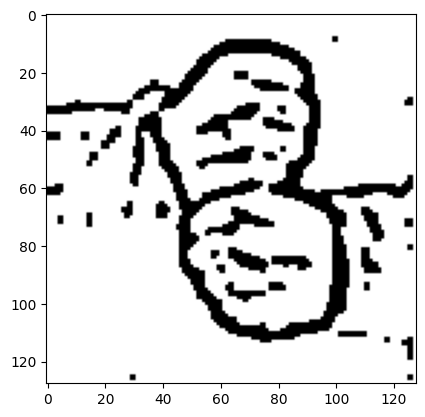

In [ ]:
minValue=50
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
IMAGE_FILES = ["/content/indian-sign-language/Train/G/107.jpg"]
for idx, file in enumerate(IMAGE_FILES):
  img=cv2.imread(file)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(5,5),2)

  th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
  ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
  res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel)
  res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR)
transform = tt.Compose([tt.ToTensor(),tt.Resize(size = (128,128))])
img= transform(res)

model= models.resnet18(pretrained=False)
in_features = model._modules['fc'].in_features
model._modules['fc'] = nn.Linear(in_features, target_num, bias=True)
model= model.to(device)


model.load_state_dict(torch.load("/content/drive/MyDrive/IndianVaishnaviWithMorphresnet18.pth",map_location=torch.device('cpu')))
model.eval()

plt.imshow(img.permute(1,2,0))
print(img.shape)
print(' Predicted:', predict_image(img, model))

